<a href="https://colab.research.google.com/github/rupesh0402/SentimentAnalysis/blob/main/Sentiment_analysis_NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Loading Data and getting Insights

In [58]:
df = pd.read_csv("/content/Restaurant_Reviews.tsv", delimiter="\t", quoting = 3)

In [59]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [60]:
#so the data is equally divided into positive and negative reviews
df['Liked'].value_counts()

1    500
0    500
Name: Liked, dtype: int64

# Loading NLTK Sentiment Analyser

In [61]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [62]:
sia.polarity_scores('this is the happiest day of my life')

{'compound': 0.6369, 'neg': 0.0, 'neu': 0.625, 'pos': 0.375}

# Result after Sentiment Analysis using NLTK

In [63]:
res = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    res.append(sia.polarity_scores(text))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
res[:10]

[{'compound': 0.5994, 'neg': 0.0, 'neu': 0.435, 'pos': 0.565},
 {'compound': -0.3412, 'neg': 0.445, 'neu': 0.555, 'pos': 0.0},
 {'compound': -0.5574, 'neg': 0.34, 'neu': 0.66, 'pos': 0.0},
 {'compound': 0.6908, 'neg': 0.093, 'neu': 0.585, 'pos': 0.322},
 {'compound': 0.6249, 'neg': 0.0, 'neu': 0.728, 'pos': 0.272},
 {'compound': -0.6908, 'neg': 0.451, 'neu': 0.451, 'pos': 0.098},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.5719, 'neg': 0.0, 'neu': 0.802, 'pos': 0.198},
 {'compound': 0.6249, 'neg': 0.0, 'neu': 0.494, 'pos': 0.506},
 {'compound': 0.6249, 'neg': 0.0, 'neu': 0.196, 'pos': 0.804}]

In [65]:
vaders = pd.DataFrame(res)
vaders = pd.concat([df, vaders],axis = 1)
vaders

,Review,Liked,neg,neu,pos,compound
0,Wow... Loved this place.,1,0.000,0.435,0.565,0.5994
1,Crust is not good.,0,0.445,0.555,0.000,-0.3412
2,Not tasty and the texture was just nasty.,0,0.340,0.660,0.000,-0.5574
3,Stopped by during the late May bank holiday of...,1,0.093,0.585,0.322,0.6908
4,The selection on the menu was great and so wer...,1,0.000,0.728,0.272,0.6249
...,...,...,...,...,...,...
995,I think food should have flavor and texture an...,0,0.000,1.000,0.000,0.0000
996,Appetite instantly gone.,0,0.000,1.000,0.000,0.0000
997,Overall I was not impressed and would not go b...,0,0.242,0.758,0.000,-0.3724
998,"The whole experience was underwhelming, and I ...",0,0.000,1.000,0.000,0.0000


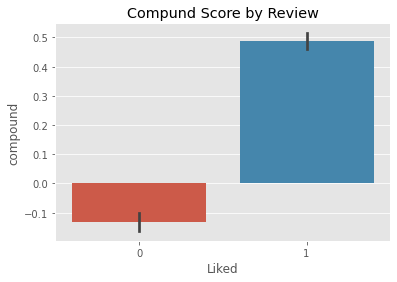

In [66]:
ax = sns.barplot(data=vaders, x='Liked', y='compound')
ax.set_title('Compund Score by Review')
plt.show()

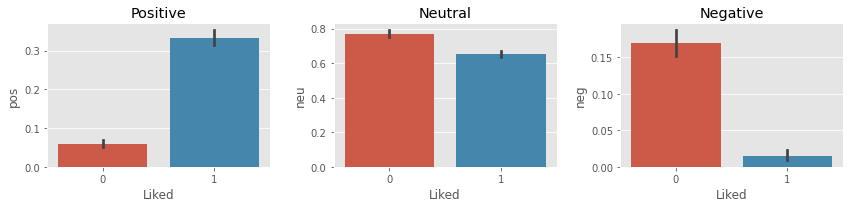

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Liked', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Liked', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Liked', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# using Transfer Learning 

## Using HugginFace Roberta Pretrained Model

### Importing Required libraries

In [68]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [69]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [70]:
encoded_text = tokenizer('this is the happiest day of my life', return_tensors='pt')
output = model(**encoded_text)
output

SequenceClassifierOutput([('logits',
                           tensor([[-2.2372, -0.9660,  4.1230]], grad_fn=<AddmmBackward0>))])

In [71]:
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.00171559, 0.00611608, 0.9921682 ], dtype=float32)

In [72]:
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

#as its working we can create function to apply on all the data

{'roberta_neg': 0.001715587, 'roberta_neu': 0.0061160754, 'roberta_pos': 0.9921682}


In [73]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict



# Using Roberta to Analyse data

In [74]:
robert = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    robert.append(polarity_scores_roberta(text))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [75]:
robert[:10]

[{'roberta_neg': 0.0023032527,
  'roberta_neu': 0.010709419,
  'roberta_pos': 0.9869874},
 {'roberta_neg': 0.9641836,
  'roberta_neu': 0.03222792,
  'roberta_pos': 0.0035885852},
 {'roberta_neg': 0.9772264,
  'roberta_neu': 0.019545527,
  'roberta_pos': 0.00322819},
 {'roberta_neg': 0.0022146236,
  'roberta_neu': 0.029860739,
  'roberta_pos': 0.9679246},
 {'roberta_neg': 0.0023891982,
  'roberta_neu': 0.016415488,
  'roberta_pos': 0.98119545},
 {'roberta_neg': 0.97581613,
  'roberta_neu': 0.021742878,
  'roberta_pos': 0.0024410258},
 {'roberta_neg': 0.7693391,
  'roberta_neu': 0.21348815,
  'roberta_pos': 0.017172763},
 {'roberta_neg': 0.22863284,
  'roberta_neu': 0.7040148,
  'roberta_pos': 0.06735239},
 {'roberta_neg': 0.0024940586,
  'roberta_neu': 0.025747484,
  'roberta_pos': 0.9717586},
 {'roberta_neg': 0.0066756904,
  'roberta_neu': 0.11391738,
  'roberta_pos': 0.8794069}]

In [76]:
roberta = pd.DataFrame(robert)
#roberta = pd.concat([df, roberta],axis = 1)
#roberta

# or to compare in a better way we can concatenate both vader data(NLTK data) and the Roberta data
vaders = pd.concat([vaders, roberta],axis = 1)
vaders

,Review,Liked,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,Wow... Loved this place.,1,0.000,0.435,0.565,0.5994,0.002303,0.010709,0.986987
1,Crust is not good.,0,0.445,0.555,0.000,-0.3412,0.964184,0.032228,0.003589
2,Not tasty and the texture was just nasty.,0,0.340,0.660,0.000,-0.5574,0.977226,0.019546,0.003228
3,Stopped by during the late May bank holiday of...,1,0.093,0.585,0.322,0.6908,0.002215,0.029861,0.967925
4,The selection on the menu was great and so wer...,1,0.000,0.728,0.272,0.6249,0.002389,0.016415,0.981195
...,...,...,...,...,...,...,...,...,...
995,I think food should have flavor and texture an...,0,0.000,1.000,0.000,0.0000,0.505633,0.440573,0.053794
996,Appetite instantly gone.,0,0.000,1.000,0.000,0.0000,0.408202,0.545063,0.046735
997,Overall I was not impressed and would not go b...,0,0.242,0.758,0.000,-0.3724,0.960627,0.036204,0.003169
998,"The whole experience was underwhelming, and I ...",0,0.000,1.000,0.000,0.0000,0.956427,0.040721,0.002852
